# Neural Image Caption
## Show and Tell: Neural Image Caption Generator
##### Based on the following paper https://arxiv.org/pdf/1411.4555.pdf

In [1]:
# data file location
data_dir = './Flickr8k_Dataset/'
train_captions_file = './Flickr8k_text/Flickr8k.token.txt'

In [2]:
# variables
start_word = 'startseq'
end_word = 'endseq'
unknown_word = 'unk'
extracted_features_file = './features.pkl'
extracted_val_features_file = './validation_features.pkl'
embedding_size = 256
lstm_units = 256
nb_epochs = 20

In [3]:
# list of train and validation images
train_image_id_list = []
val_image_id_list = []

In [4]:
# create list of train image ids
train_images = './Flickr8k_text/Flickr_8k.trainImages.txt'
with open(train_images, 'r') as f:
    image_list = f.readlines()
    for image in image_list:
        train_image_id_list.append(image.split('.')[0])

In [5]:
# create list of validation image ids
val_images = './Flickr8k_text/Flickr_8k.devImages.txt'
with open(val_images, 'r') as f:
    image_list = f.readlines()
    for image in image_list:
        val_image_id_list.append(image.split('.')[0])

In [6]:
n_train_images = len(train_image_id_list)
n_val_images = len(val_image_id_list)

In [7]:
# open train captions file for reading
f = open(train_captions_file, 'r')

# read file
sentences = f.readlines()

In [8]:
# function for generating data
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def generate_data(sentences):
    ''' generates data
        Parameters:
            list: sentences(each list item contains data in the format
                            'image_id.jpg#caption_index', 'A caption describing the image.\n')
        Return format:
            list: image_ids, dict: captions
    '''
    
    image_ids = []
    captions = {}
    
    for sentence in sentences:
        # returns data in the form ['image_id.jpg#caption_index', 'A caption describing the image.\n']
        image_and_caption_index, caption = sentence.split('\t')
        # extract image id
        image_id = image_and_caption_index.split('.')[0]
        # converts caption to the form 'startseq A caption describing the image.\n endseq'
        caption = start_word + ' ' + caption + ' ' + end_word
        # split caption into invidividual words to remove any punctuation and special characters
        caption = text_to_word_sequence(caption)
        # join back the split words
        # converts caption to the form 'startseq a caption describing the image endseq'
        caption = ' '.join(caption)

        # append image id to the list and caption to a dictionary where key is the corresponding image id
        if image_id not in image_ids:
            image_ids.append(image_id)
            captions[image_id] = []
        captions[image_id].append(caption)
        
    # return generated data
    return image_ids, captions

In [9]:
# generate data
image_ids, captions = generate_data(sentences)

In [10]:
# verifying if the data is correct or not
print(len(image_ids))
print(len(captions))

8092
8092


In [11]:
# create a list of all captions
all_captions = []
for image_id, caption in captions.items():
    all_captions += caption

In [12]:
# get the number of all the captions in the file
num_all_captions = len(all_captions)
print(num_all_captions)

40460


In [13]:
# create a word tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [14]:
# fit tokenizer on all captions
tokenizer.fit_on_texts(all_captions)

In [15]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8496


In [16]:
# find the maximum length of caption
max_len = max(len(text_to_word_sequence(caption)) for caption in all_captions)
print(max_len)

39


In [17]:
# VGG16 model pretrained on ImageNet to be used as our CNN encoder
from tensorflow.keras.applications.vgg16 import VGG16

In [18]:
# init VGG16 model pretrained on ImageNet
base_model = VGG16(include_top=True, weights='imagenet')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
# create a new model using VGG16 as the base layer but without the softmax prediction layer
from tensorflow.keras.models import Model

In [20]:
# finally create the feature extractor model
feature_extractor_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
feature_extractor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
# function that returns extracted feature of an image
def get_image_features(image_id):
    image = data_dir + image_id + '.jpg'
    feature = []
    try:
        image = load_img(image, target_size=(224, 224))
        
        # pre-process image so that it is compatible with VGG16 model
        image = img_to_array(image)
        image = image.reshape((1, 224, 224, 3))
        image = preprocess_input(image)

        feature = feature_extractor_model.predict(image)
    except FileNotFoundError:
        pass
    
    return feature

In [22]:
# extract features from every image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

features = {}

for image_id in image_ids:    
    feature = get_image_features(image_id)
    features[image_id] = feature

In [23]:
# store train features in a pickle file
from pickle import dump
dump(features, open(extracted_features_file, 'wb'))

In [24]:
# open extracted features file
from pickle import load
f_extracted = load(open(extracted_features_file, 'rb'))

In [25]:
# function which returns features and label in input format(of the encoder model)
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def load_data(image_id, caption_list, data_file):
    X_encoder = []
    X_decoder = []
    y_decoder = []
        
    # load features from file
    image = data_file[image_id]
    
    # integer encode the caption
    integer_encoded_caption_list = tokenizer.texts_to_sequences(caption_list)
    
    # this loop is used to create input and output data list
    # 'startseq a simple caption endseq' (actually the list will consist of integer which are mapped to these words) is converted to
    #   INPUT                         OUTPUT
    # 'startseq'                       'a'
    # 'startseq a'                   'simple'
    # 'startseq a simple'            'caption'
    # 'startseq a simple caption'    'endseq'
    for caption in integer_encoded_caption_list:
        for i in range(1, len(caption)):
            in_seq = caption[:i]
            out_seq = caption[i]
                
            X_encoder.append(image)
            X_decoder.append(in_seq)
            y_decoder.append(out_seq)
        
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)

In [26]:
# function which yields train data to fit_generator method of keras model
def train_data_generator():
    while True:
        for image_id in train_image_id_list:
            caption_list = []
            try:
                caption_list = captions[image_id]
            except KeyError:
                pass
            if len(caption_list) == 0:
                continue
            if len(f_extracted[image_id]) == 0:
                continue
                
            X_encoder, X_decoder, y_decoder = load_data(image_id, caption_list, f_extracted)
            # reshape the image features vector
            X_encoder = X_encoder.reshape((X_encoder.shape[0], 4096))
            # pad the input to LSTM cell
            X_decoder = pad_sequences(X_decoder, maxlen=max_len)
            # convert output to one hot encoded vector
            y_decoder = to_categorical(y_decoder, num_classes=vocab_size)
            
            yield [[X_encoder, X_decoder], y_decoder]

In [27]:
def val_data_generator():
    while True:
        for image_id in val_image_id_list:
            caption_list = []
            try:
                caption_list = captions[image_id]
            except KeyError:
                pass
            if len(caption_list) == 0:
                continue
            if len(f_extracted[image_id]) == 0:
                continue
                
            X_encoder, X_decoder, y_decoder = load_data(image_id, caption_list, f_extracted)
            # reshape the image features vector
            X_encoder = X_encoder.reshape((X_encoder.shape[0], 4096))
            # pad the input to LSTM cell
            X_decoder = pad_sequences(X_decoder, maxlen=max_len)
            # convert output to one hot encoded vector
            y_decoder = to_categorical(y_decoder, num_classes=vocab_size)
            
            yield [[X_encoder, X_decoder], y_decoder]

In [28]:
# imports for CNN-RNN encoder-decoder model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, Input, TimeDistributed
from tensorflow.keras.layers import concatenate

In [29]:
# create image encoder model(CNN)
input_image_encoder = Input(shape=(4096,))
dense_image_encoder = Dense(lstm_units, activation='relu')(input_image_encoder)
output_image_encoder = RepeatVector(max_len)(dense_image_encoder)

# create sequence decoder model(RNN)
input_sequence_decoder = Input(shape=(max_len,))
embedding_sequence_model = Embedding(vocab_size, embedding_size, mask_zero=True)(input_sequence_decoder)
lstm_sequence_model = LSTM(lstm_units, return_sequences=True)(embedding_sequence_model)
td_sequence_model = TimeDistributed(Dense(embedding_size, activation='relu'))(lstm_sequence_model)

# merge CNN and RNN layers
# known to be slightly better that init-inject, pre-inject and par-inject models? 
merged = concatenate([output_image_encoder, td_sequence_model])

# language model
lstm_encoder_decoder = LSTM(lstm_units, return_sequences=False)(merged)
dense_encoder_decoder = Dense(lstm_units, activation='relu')(lstm_encoder_decoder)
output_encoder_decoder = Dense(vocab_size, activation='softmax')(dense_encoder_decoder)

# convert these layers into a keras model
model = Model(inputs=[input_image_encoder, input_sequence_decoder], outputs=output_encoder_decoder)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 256)      2174976     input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1048832     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM

In [30]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# callback for saving model
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="NIC-Flickr8k-{epoch:02d}-{loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [32]:
# create generator callbacks
generator_train = train_data_generator()
generator_val = val_data_generator()

#### Either train the model or load from previously trained model

In [ ]:
# randomize the train and validation data
import random

for i in range(nb_epochs):
    keys = list(captions.keys())
    random.shuffle(keys)
    captions_shuffled = {key: captions[key] for key in keys}
    captions = captions_shuffled
    model.fit_generator(generator_train, epochs=1, verbose=1, steps_per_epoch=n_train_images, callbacks=callbacks_list, validation_data=generator_val, validation_steps=n_val_images)

In [33]:
# load previously trained model trained on 25 epochs with a final loss of 3.4738
model.load_weights('NIC-Flickr8k-25-3.4738.h5')

In [34]:
# create test image id list
test_image_id_list = []

# create list of test images
test_images = './Flickr8k_text/Flickr_8k.testImages.txt'
with open(test_images, 'r') as f:
    image_list = f.readlines()
    for image in image_list:
        test_image_id_list.append(image.split('.')[0])

In [35]:
# load a specific image for testing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# extract features of a random test file
test_image_id = test_image_id_list[513] # number chosen by randomly smashing the keyboard keys

image_feature = get_image_features(test_image_id)

In [36]:
# create unique integer to word mapping
int_to_word = {int:word for word, int in tokenizer.word_index.items()}

In [37]:
# initialize seed word
seed_word = start_word
print(seed_word)

startseq


In [38]:
# just so that the train, val and test data has similar non-confusing names
X_encoder = image_feature

In [39]:
# imports for loading image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image = data_dir + test_image_id + '.jpg'

test_image = cv2.imread(image)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

In [40]:
# generate sequence
for i in range(max_len):
    # integer encode seed word
    sequence = tokenizer.texts_to_sequences([seed_word])
    
    # pad sequence
    sequence = pad_sequences(sequence, maxlen=max_len)
    
    # create input tensor
    X_test = [X_encoder, sequence]
    
    # predict next word in sequence
    y_pred = model.predict(X_test, verbose=0)
    
    # calculate maximum index from one hot encoded tensor
    y_pred = np.argmax(y_pred)
    
    # convert index back to word
    word = int_to_word[y_pred]
    
    # break if word cannot be mapped back
    if word is None:
        break
        
    # append current predicted word to the sequence which will be the input in the next timestep
    seed_word += ' ' + word
    
    # break if endseq is predicted
    if word == 'endseq':
        break

startseq a dog is running on a grassy field endseq


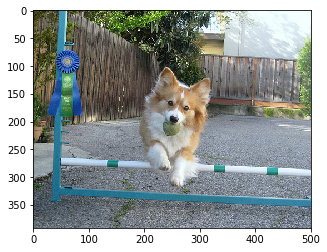

In [41]:
# print generated sequence and the image
print(seed_word)
plt.imshow(test_image)